# หาค่าสูงสุดรายชั่วโมงของ dbz ในแต่ละจุดภาพ cappi ในชั่วโมงนั้นๆ
* อ่าน uf ของราย 15 นาที จำนวน 4 ไฟล์ เข้ามาใน pyart
* กรองค่า noise ด้วย Signal to Noise ratio
* ปรับแก้ attenuation
* สร้าง cartesian cappi จากทุก PPIs ตามระดับความสูง
* แปลงข้อมูล cartesian ให้อยู่ใน xaarray เพื่อง่ายต่อการ composite max
* หาค่า max ของแต่ละ pixel ด้วยแกนเวลา time
* ส่งออกเซฟข้อมูล maximum dbz hourly PPI ที่ต้องการไปเป็น geotif เพื่อประมวลผลในการสกัดจุดสถานีฝนภาคพื้นดินต่อไป

In [1]:
'''
2024/01/09 
พัฒนาโค้ดโดย รศ.ดร.นัฐพล มหาวิค 
email:nattaponm@nu.ac.th 
ยูทูป:https://www.youtube.com/@Nattapon_Mahavik/playlists 
หนังสือ: เรดาร์ตรวจอากาศทางอุตุนิยมวิทยา https://www.chulabook.com/education/144567
Github: https://github.com/nattaponm
Scopus: https://www.scopus.com/authid/detail.uri?authorId=55583236600
'''

'\n2024/01/09 \nพัฒนาโค้ดโดย รศ.ดร.นัฐพล มหาวิค \nemail:nattaponm@nu.ac.th \nยูทูป:https://www.youtube.com/@Nattapon_Mahavik/playlists \nหนังสือ: เรดาร์ตรวจอากาศทางอุตุนิยมวิทยา https://www.chulabook.com/education/144567\nGithub: https://github.com/nattaponm\nScopus: https://www.scopus.com/authid/detail.uri?authorId=55583236600\n'

In [2]:
import numpy as np
import matplotlib.pyplot as pl
import pyart
import xarray as xr
import rioxarray


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



<frozen importlib._bootstrap>:283: DeprecationWarning: the load_module() method is deprecated and slated for removal in Python 3.12; use exec_module() instead


# อ่านไฟล์ uf แต่ละช่วงเวลา

In [3]:
radar1 = pyart.io.read('../1data/0radar/1radar_tmd/PHS240@201807201000.uf.bz2') 
radar2 = pyart.io.read('../1data/0radar/1radar_tmd/PHS240@201807201030.uf.bz2') 
radar3 = pyart.io.read('../1data/0radar/1radar_tmd/PHS240@201807201045.uf.bz2') 
radar4 = pyart.io.read('../1data/0radar/1radar_tmd/PHS240@201807201100.uf.bz2')


# หาค่า signal to noise ratio แล้วแอดฟิวด์

In [4]:
def SNR(radar):
    snr = pyart.retrieve.calculate_snr_from_reflectivity(radar, refl_field='reflectivity',toa=15000.0) #15000 ทดลองเอง
    radar.add_field('signal_to_noise_ratio', snr, replace_existing=True)
    gtfilter = pyart.filters.moment_and_texture_based_gate_filter(radar, phi_field='differential_phase')
    gtfilter.exclude_below('signal_to_noise_ratio', 5) #ใช้ค่า snr  = 10 
    gtfilter.exclude_above('signal_to_noise_ratio', 70) #ใช้ค่า snr  = 60 
    # แอดฟิวด์ที่ได้กรองสัญญาณรบกวนออกไป เอาโค้ดมาจาก  https://github.com/ARM-DOE/pyart/issues/763
    radar.add_field_like('reflectivity', 'reflectivity_copy',
                     radar.fields['reflectivity']['data'].copy())
    nf = radar.fields['reflectivity_copy']
    nf['data'] = np.ma.masked_where(gtfilter.gate_excluded , nf['data'])
    radar.add_field('filtered_reflectivity', nf, replace_existing=True)
    return radar

In [5]:
radar1 = SNR(radar1)
radar2 = SNR(radar2)
radar3 = SNR(radar3)
radar4 = SNR(radar4)

# ปรับแก้ attenuation
* โค้ด https://arm-doe.github.io/pyart/examples/correct/plot_attenuation.html
* โค้ด https://openradarscience.org/erad2022/notebooks/pyart/exercice1_swiss_thunderstorm.html
* โค้ดประมวลผล PhiDP https://jjhelmus.github.io/pyart/dev/auto_examples/correct/plot_lp_phase_proc.html

In [6]:
def atten_correct(radar):
    # คำนวณฟิวด์ normalized coherent power NCP ขึ้นมาใหม่
    ncp_values = np.ones((radar.nrays, radar.ngates))
    ncp = pyart.config.get_metadata('normalized_coherent_power')
    ncp['data'] = ncp_values
    radar.add_field('normalized_coherent_power', ncp)

    # ปรับแก้ค่า phidp ก่อน เพื่อให้ได้ค่า proc_dp_phase_shift ที่จะนำไปใช้ในการปรับแก้ attenuation
    phidp, kdp = pyart.correct.phase_proc_lp(radar, 0.0, LP_solver='pyglpk',debug=True)
    radar.add_field('proc_dp_phase_shift', phidp)
    radar.add_field('recalculated_diff_phase', kdp)

    # ปรับแก้ attenuation correction โค้ด จาก https://arm-doe.github.io/pyart/examples/correct/plot_attenuation.html
    spec_at, cor_z = pyart.correct.calculate_attenuation(
        radar,
        0,
        fzl=4500.0,
        refl_field="filtered_reflectivity",
        ncp_field="normalized_coherent_power",
        rhv_field="cross_correlation_ratio",
        phidp_field="proc_dp_phase_shift",
    )
    radar.add_field("specific_attenuation", spec_at)
    radar.add_field("corrected_filtered_reflectivity", cor_z)
    return radar

In [7]:
radar1 = atten_correct(radar1)
radar2 = atten_correct(radar2)
radar3 = atten_correct(radar3)
radar4 = atten_correct(radar4)

Unfolding


C:\Users\Admin\anaconda3\envs\ml_dl_n1\lib\site-packages\pyart\correct\phase_proc.py:170: RuntimeWarning: invalid value encountered in sqrt
  _noise = smooth_and_trim(np.sqrt((line - signal) ** 2), window_len=wl)
C:\Users\Admin\anaconda3\envs\ml_dl_n1\lib\site-packages\pyart\correct\phase_proc.py:171: RuntimeWarning: divide by zero encountered in divide
  return abs(signal) / _noise


Exec time:  1.327010154724121
Doing  0
Doing  1
Doing  2
Doing  3


C:\Users\Admin\anaconda3\envs\ml_dl_n1\lib\site-packages\pyart\correct\phase_proc.py:1154: DeprecationWarning: Please use `convolve1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  kdp = (scipy.ndimage.filters.convolve1d(proc_ph['data'], sobel, axis=1) /
C:\Users\Admin\anaconda3\envs\ml_dl_n1\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Admin\anaconda3\envs\ml_dl_n1\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Unfolding
Exec time:  1.3840203285217285
Doing  0
Doing  1
Doing  2
Doing  3


C:\Users\Admin\anaconda3\envs\ml_dl_n1\lib\site-packages\pyart\correct\phase_proc.py:1154: DeprecationWarning: Please use `convolve1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  kdp = (scipy.ndimage.filters.convolve1d(proc_ph['data'], sobel, axis=1) /


Unfolding
Exec time:  1.39271879196167
Doing  0
Doing  1
Doing  2
Doing  3


C:\Users\Admin\anaconda3\envs\ml_dl_n1\lib\site-packages\pyart\correct\phase_proc.py:1154: DeprecationWarning: Please use `convolve1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  kdp = (scipy.ndimage.filters.convolve1d(proc_ph['data'], sobel, axis=1) /


Unfolding
Exec time:  1.4419887065887451
Doing  0
Doing  1
Doing  2
Doing  3


C:\Users\Admin\anaconda3\envs\ml_dl_n1\lib\site-packages\pyart\correct\phase_proc.py:1154: DeprecationWarning: Please use `convolve1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  kdp = (scipy.ndimage.filters.convolve1d(proc_ph['data'], sobel, axis=1) /


# สร้าง grid Gridding PPI to cartesian¶

In [8]:
def gridding(radar):
    #radar_p=radar.extract_sweeps([0]) # เลือกมุมยก 0 คือ มุมแรก
    lat_0 = radar.latitude['data'][0]
    lon_0 = radar.longitude['data'][0]

    shape = (11, 241, 241)
    grid = pyart.map.grid_from_radars(
                radar,
                grid_shape=shape, #Number of points in the grid (z, y, x)
                grid_limits=((0, 10000), (-240000, 240000), (-240000, 240000)),    # ตั้งค่า(2000, 2000) หมายความว่าต้องการให้สร้างกริด cappi ที่ระดับ 2 km จาก ppi ดังกล่าว
                grid_origin = (lat_0,lon_0),
                fields=['corrected_filtered_reflectivity'],
                roi_func= 'constant', constant_roi=4000.0 # เปลี่ยนฟังก์ชั่นเป็น roi_func= 'constant' เพื่อต้องการให้ดึงขัอมูลจุดของมุม ppi ที่อยู่ในระดับสูงมาคิดน้ำหนักด้วย สังเกตตรงกลางสถานีจะมีค่าฝนแล้ว
    )
    return grid

In [9]:
grid1 = gridding(radar1)
grid2 = gridding(radar2)
grid3 = gridding(radar3)
grid4 = gridding(radar4)


In [10]:
ds = grid1.to_xarray()
ds

<xarray.Dataset>
Dimensions:                          (time: 1, z: 11, y: 241, x: 241)
Coordinates:
  * time                             (time) object 2018-07-20 10:00:03
  * z                                (z) float64 0.0 1e+03 2e+03 ... 9e+03 1e+04
    lat                              (y) float64 14.61 14.62 ... 18.9 18.92
    lon                              (x) float64 97.99 98.01 ... 102.4 102.4
  * y                                (y) float64 -2.4e+05 -2.38e+05 ... 2.4e+05
  * x                                (x) float64 -2.4e+05 -2.38e+05 ... 2.4e+05
Data variables:
    corrected_filtered_reflectivity  (time, z, y, x) float64 nan nan ... nan nan
    ROI                              (time, z, y, x) float32 4e+03 ... 4e+03

# ทดสอบดูผล

C:\Users\Admin\anaconda3\envs\ml_dl_n1\lib\site-packages\pyart\graph\gridmapdisplay.py:213: UserWarning: No projection was defined for the axes. Overridding defined axes and using default axes with projection Mercator.
  warnings.warn(


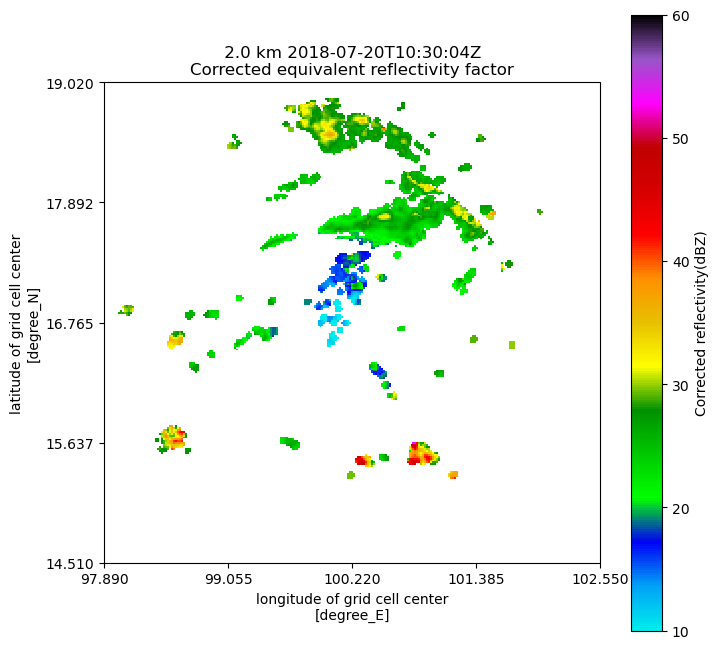

In [11]:
fig = pl.figure(figsize=[8, 8])
display = pyart.graph.GridMapDisplay(grid2)
display.plot_grid("corrected_filtered_reflectivity", level=2, cmap=pyart.graph.cm.NWSRef, vmin=10, vmax=60)

# อ่าน grid 4 ช่วงเวลาเข้า xaaray เพือ่หาค่า maximum

In [12]:
# แปลง grid ใน pyart ไปสู่ข้อมูล xaaray
def convertGrid2Xaaray(grid):
    ds = grid.to_xarray()
    grid_p=ds['corrected_filtered_reflectivity'][0,2,:,:]  #เวลา 0 คือ มีเวลาเดียวมี 2 ระดับความสูงของ cappi กิโลเมตร
    return grid_p

In [13]:
grid1=convertGrid2Xaaray(grid1)
grid2=convertGrid2Xaaray(grid2)
grid3=convertGrid2Xaaray(grid3)
grid4=convertGrid2Xaaray(grid4)   
grid4

<xarray.DataArray 'corrected_filtered_reflectivity' (y: 241, x: 241)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    time     object 2018-07-20 11:00:04
    z        float64 2e+03
    lat      (y) float64 14.61 14.62 14.64 14.66 ... 18.87 18.88 18.9 18.92
    lon      (x) float64 97.99 98.01 98.03 98.04 ... 102.4 102.4 102.4 102.4
  * y        (y) float64 -2.4e+05 -2.38e+05 -2.36e+05 ... 2.38e+05 2.4e+05
  * x        (x) float64 -2.4e+05 -2.38e+05 -2.36e+05 ... 2.38e+05 2.4e+05
Attributes:
    units:          dBZ
    standard_name:  corrected_equivalent_reflectivity_factor
    long_name:      Corrected reflectivity
    coordinates:    elevation azimuth range
    _FillValue:     -9999.0

In [14]:
con_xr=xr.concat([grid1, grid2, grid3, grid4],dim='time')

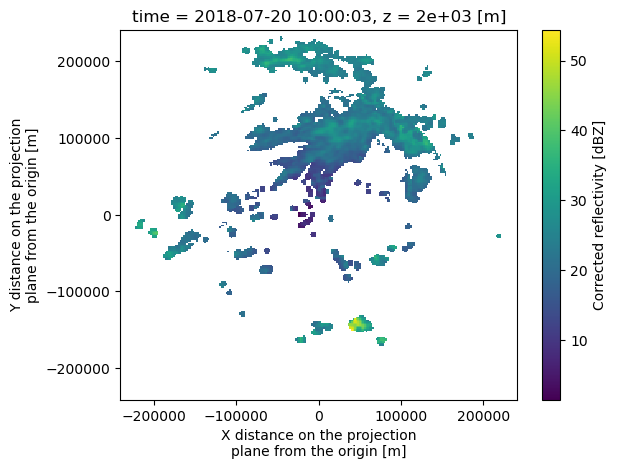

In [15]:
con_xr[0,:,:].plot()

# หาค่า max เพื่อสร้าง composite CAPPI ค่า dbz สูงสุดรายชั่วโมงนั้น ๆ

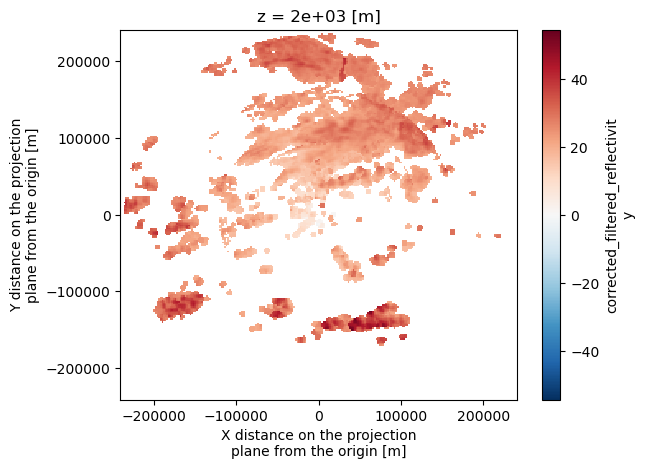

In [16]:
cappi_max_hr = con_xr.max(dim='time')
cappi_max_hr.plot()

# ส่งออกไฟล์ผลลัพธ์ที่มีพิกัดภูมิศาสตร์

In [17]:
# เปลี่ยนอินเด็กซ์ เป็น lat-lon
cappi_max_hr = cappi_max_hr.to_dataset()
cappi_max_hr = cappi_max_hr.squeeze()
cappi_max_hr = cappi_max_hr.set_index(x="lon", y="lat") #แก้ปัญหาตรงนี้
cappi_max_hr



<xarray.Dataset>
Dimensions:                          (y: 241, x: 241)
Coordinates:
    z                                float64 2e+03
  * y                                (y) float64 14.61 14.62 ... 18.9 18.92
  * x                                (x) float64 97.99 98.01 ... 102.4 102.4
Data variables:
    corrected_filtered_reflectivity  (y, x) float64 nan nan nan ... nan nan nan

In [18]:
cappi_max_hr.rio.set_spatial_dims(x_dim='x', y_dim='y', inplace=True) 
cappi_max_hr.rio.set_crs("EPSG:4326")
cappi_max_hr.rio.write_crs("EPSG:4326", inplace=True)
cappi_max_hr.rio.write_transform()
cappi_max_hr.rio.write_coordinate_system()
cappi_max_hr.rio.to_raster("../2results/cappi_max_hr.tif")

# อ่านข้อมูลเข้ามาด้วย rasterio ่ใน xrarray แล้วลอง plot ตรวจสอบ

In [19]:
ds = xr.open_rasterio("../2results/cappi_max_hr.tif")
ds

C:\Users\Admin\AppData\Local\Temp\ipykernel_8392\4194220988.py:1: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  ds = xr.open_rasterio("../2results/cappi_max_hr.tif")


<xarray.DataArray (band: 1, y: 241, x: 241)>
[58081 values with dtype=float64]
Coordinates:
  * band     (band) int32 1
  * y        (y) float64 14.61 14.62 14.64 14.66 ... 18.87 18.88 18.9 18.92
  * x        (x) float64 97.99 98.01 98.03 98.04 ... 102.4 102.4 102.4 102.4
Attributes:
    transform:      (0.01858297606624658, 0.0, 97.97871579373951, 0.0, 0.0179...
    crs:            +init=epsg:4326
    res:            (0.01858297606624658, 0.017981023856791078)
    is_tiled:       0
    nodatavals:     (nan,)
    scales:         (1.0,)
    offsets:        (0.0,)
    descriptions:   ('corrected_filtered_reflectivity',)
    AREA_OR_POINT:  Area

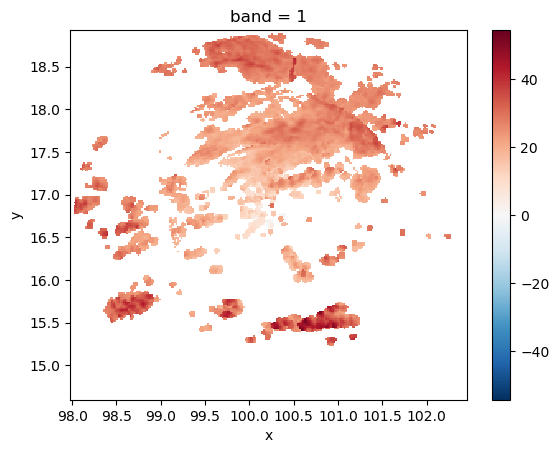

In [20]:
ds.plot()

In [21]:
ds.close()

## ผลใน qgis

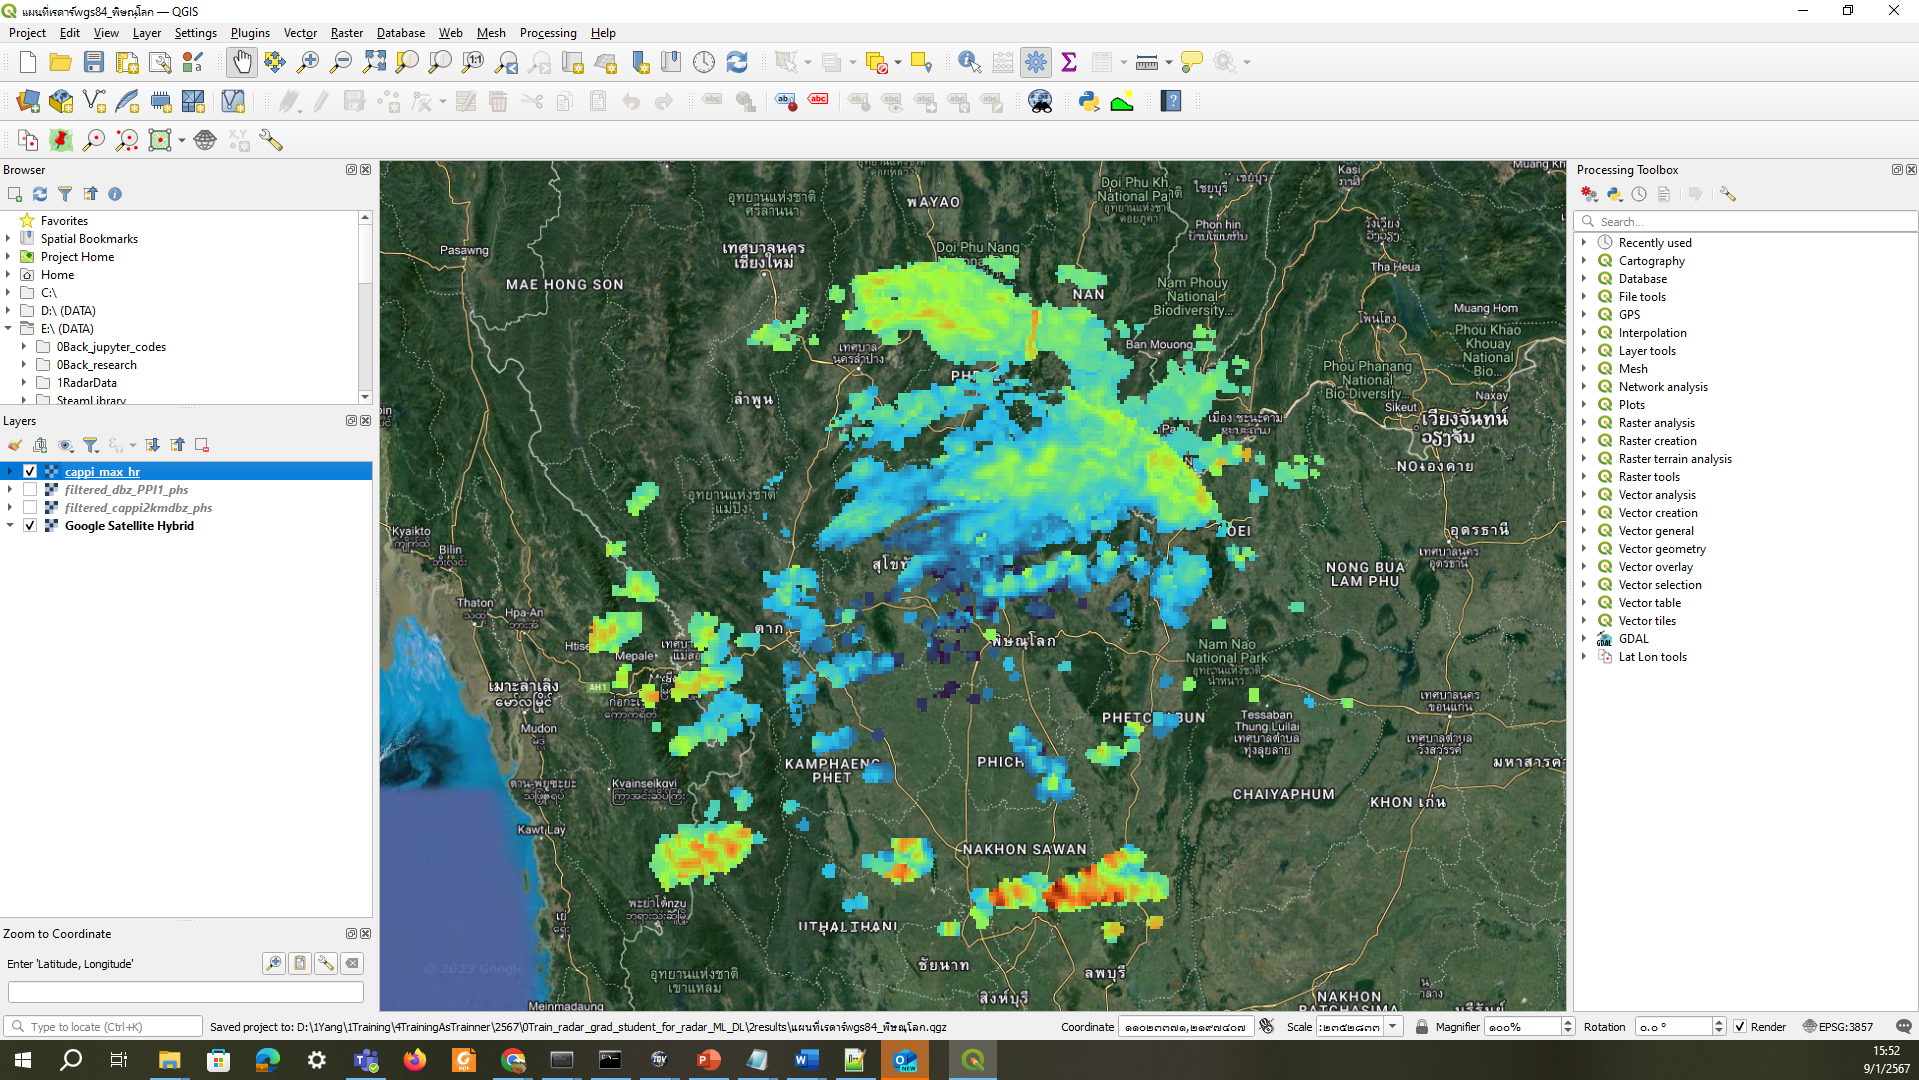

## ทดลอง
* นำโค้ดไปดัดแปลงให้สามารถรันข้อมูลได้หลาย ๆ ไฟล์ อย่างต่อเนื่อง >> หาลิสต์ชื่อไฟล์ราย15นาที >> หาลิสต์รายชั่วโมง แล้วรันลูป